# Intercomparison

**Author:** Ivan Zvonkov

**Last updated:** Nov 15, 2023

**Description:** Runs intercomparison for Sudan Gedaref, West/South Darfur, Al Jazirah, Central Darfur 2022

## 1. Setup

In [ ]:
#earthengine authenticate

In [1]:
import ee
import geemap
import sys
import pandas as pd
import geopandas as gpd
from pathlib import Path

ee.Initialize()

sys.path.append("../..")

from src.compare_covermaps import TARGETS, filter_by_bounds, generate_report, CLASS_COL, COUNTRY_COL
from src.compare_covermaps import TEST_COUNTRIES, TEST_CODE

## 2. Read in evaluation set

In [2]:
country = "GedarefDarfurAlJazirah2022"

if country not in TEST_CODE:
    print(f"WARNING: {country} not found in TEST_CODE in src/compare_covermaps.py")
if country not in TEST_COUNTRIES:
    print(f"WARNING: {country} not found in TEST_COUNTRIES in src/compare_covermaps.py")
if country not in TEST_CODE or country not in TEST_COUNTRIES:
    print("Please update src/compare_covermaps.py and restart the notebook.")
else:
    country_code = TEST_CODE[country]
    dataset_path = "../" + TEST_COUNTRIES[country]

In [3]:
if not Path(dataset_path).exists():
    print(f"WARNING: Dataset: {dataset_path} not found, run `dvc pull data/datasets from root.")
else:
    df = pd.read_csv(dataset_path)[["lat", "lon", "class_probability", "subset"]]
    df = df[(df["class_probability"] != 0.5)].copy()
    # use only test data because validation points used for harvest-dev map
    df = df[df["subset"] == "testing"].copy()
    df[CLASS_COL] = (df["class_probability"] > 0.5).astype(int)
    df[COUNTRY_COL] = country

    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="epsg:4326")
    gdf = filter_by_bounds(country_code=country_code, gdf=gdf)

## 3. Run intercomparison

In [6]:
TARGETS = {k:v for k,v in TARGETS.items()}

In [8]:
for cropmap in TARGETS.values():
    if country not in cropmap.countries:
        continue
    print(f"[{country}] sampling " + cropmap.title + "...")
    map_sampled = cropmap.extract_test(gdf).copy()
    gdf = pd.merge(gdf, map_sampled, on=["lat", "lon"], how="left")

[GedarefDarfurAlJazirah2022] sampling copernicus...
[GedarefDarfurAlJazirah2022] sampling worldcover-v100...
[GedarefDarfurAlJazirah2022] sampling worldcover-v200...
[GedarefDarfurAlJazirah2022] sampling worldcereal-v100...
[GedarefDarfurAlJazirah2022] sampling glad...
[GedarefDarfurAlJazirah2022] sampling asap...
[GedarefDarfurAlJazirah2022] sampling dynamicworld...
[GedarefDarfurAlJazirah2022] sampling gfsad-gcep...
[GedarefDarfurAlJazirah2022] sampling gfsad-lgrip...
[GedarefDarfurAlJazirah2022] sampling digital-earth-africa...
[GedarefDarfurAlJazirah2022] sampling esa-cci-africa...
[GedarefDarfurAlJazirah2022] sampling globcover-v23...
[GedarefDarfurAlJazirah2022] sampling globcover-v22...
[GedarefDarfurAlJazirah2022] sampling esri-lulc...
[GedarefDarfurAlJazirah2022] sampling nabil-etal-2021...


In [9]:
comparisons = []
for cropmap in TARGETS.keys():
    if cropmap not in gdf.columns:
        continue
    temp = gdf[[CLASS_COL, cropmap]].dropna()
    comparison = generate_report(cropmap, country, temp[CLASS_COL], temp[cropmap])
    comparisons.append(comparison)

results = pd.concat(comparisons).set_index(["dataset"])

# Add ensemble
ensemble_maps = ["glad", "worldcover-v100", "esri-lulc"] # Should be odd number
print(f"Ensemble maps: {ensemble_maps}")
ensemble = gdf[ensemble_maps].mode(axis='columns')
comparison = generate_report("ensemble-subset", country, gdf[CLASS_COL], ensemble)
comparisons.append(comparison)

results = pd.concat(comparisons).set_index(["dataset"])
results

Ensemble maps: ['glad', 'worldcover-v100', 'esri-lulc']


country  crop_f1  std_crop_f1  \
dataset                                                                  
copernicus            GedarefDarfurAlJazirah2022     0.80         0.10   
worldcover-v100       GedarefDarfurAlJazirah2022     0.77         0.10   
worldcover-v200       GedarefDarfurAlJazirah2022     0.82         0.10   
worldcereal-v100      GedarefDarfurAlJazirah2022     0.84         0.09   
glad                  GedarefDarfurAlJazirah2022     0.80         0.10   
asap                  GedarefDarfurAlJazirah2022     0.81         0.10   
dynamicworld          GedarefDarfurAlJazirah2022     0.80         0.10   
gfsad-gcep            GedarefDarfurAlJazirah2022     0.10         0.08   
gfsad-lgrip           GedarefDarfurAlJazirah2022     0.79         0.10   
digital-earth-africa  GedarefDarfurAlJazirah2022     0.82         0.10   
esa-cci-africa        GedarefDarfurAlJazirah2022     0.72         0.10   
globcover-v23         GedarefDarfurAlJazirah2022     0.29         0.11   
globcover-v22         GedarefDarfurAlJazirah2022     0.33         0.12   
esri-lulc             GedarefDarfurAlJazirah2022     0.49         0.10   
nabil-etal-2021       GedarefDarfurAlJazirah2022     0.80         0.10   
ensemble-subset       GedarefDarfurAlJazirah2022     0.78         0.10   

                      accuracy  std_acc  crop_recall_pa  std_crop_pa  \
dataset                                                                
copernicus                0.84     0.02            0.78         0.03   
worldcover-v100           0.83     0.02            0.70         0.03   
worldcover-v200           0.86     0.02            0.81         0.03   
worldcereal-v100          0.87     0.02            0.87         0.03   
glad                      0.85     0.02            0.78         0.03   
asap                      0.84     0.02            0.82         0.03   
dynamicworld              0.83     0.02            0.87         0.03   
gfsad-gcep                0.60     0.03            0.06         0.02   
gfsad-lgrip               0.83     0.02            0.79         0.03   
digital-earth-africa      0.86     0.02            0.81         0.03   
esa-cci-africa            0.74     0.02            0.87         0.03   
globcover-v23             0.46     0.03            0.28         0.03   
globcover-v22             0.49     0.03            0.31         0.03   
esri-lulc                 0.71     0.03            0.35         0.03   
nabil-etal-2021           0.84     0.02            0.80         0.03   
ensemble-subset           0.84     0.02            0.69         0.03   

                      noncrop_recall_pa  std_noncrop_pa  crop_precision_ua  \
dataset                                                                      
copernicus                         0.89            0.02               0.82   
worldcover-v100                    0.92            0.02               0.85   
worldcover-v200                    0.90            0.02               0.84   
worldcereal-v100                   0.86            0.02               0.81   
glad                               0.89            0.02               0.82   
asap                               0.86            0.02               0.79   
dynamicworld                       0.81            0.02               0.75   
gfsad-gcep                         0.96            0.01               0.47   
gfsad-lgrip                        0.86            0.02               0.79   
digital-earth-africa               0.89            0.02               0.83   
esa-cci-africa                     0.65            0.02               0.62   
globcover-v23                      0.59            0.02               0.31   
globcover-v22                      0.60            0.02               0.34   
esri-lulc                          0.95            0.01               0.82   
nabil-etal-2021                    0.87            0.02               0.80   
ensemble-subset                    0.94            0.02               0.88   

      

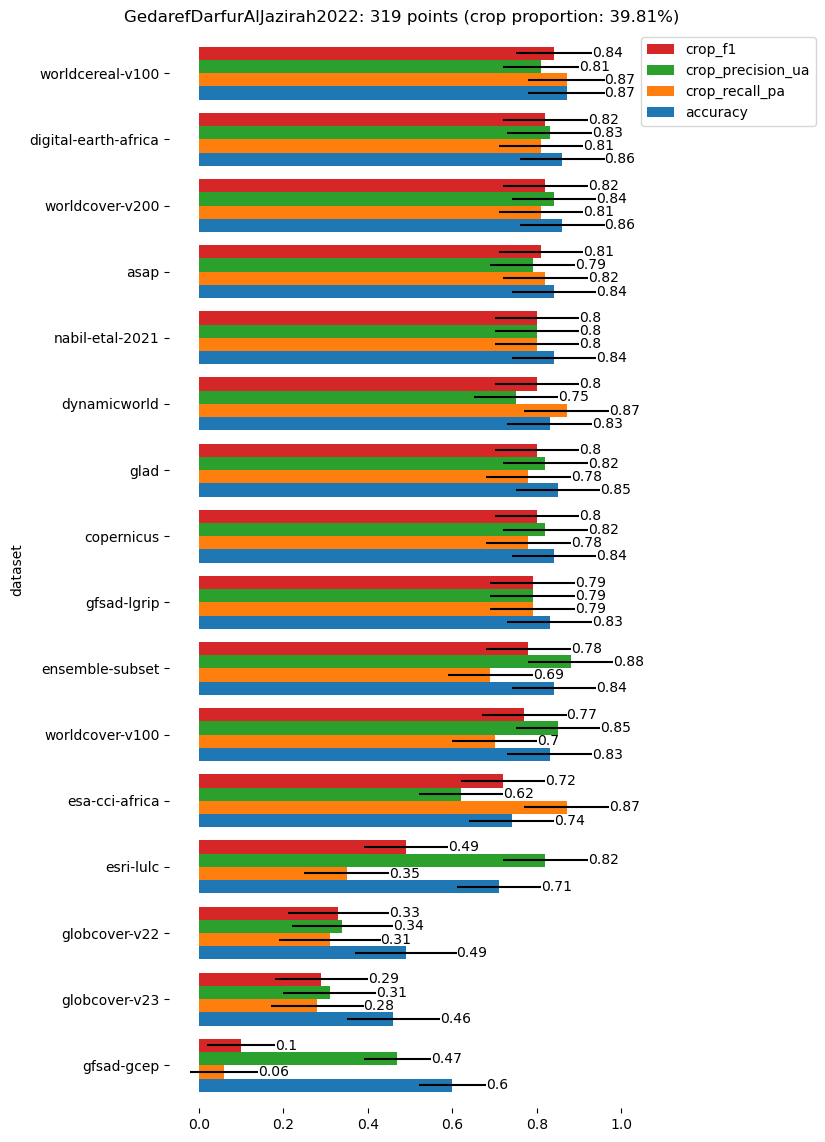

In [11]:
crop_proportion = round(gdf[CLASS_COL].value_counts(normalize=True)[1], 4) * 100
ax = results.sort_values("crop_f1").plot(
    y=["accuracy", "crop_recall_pa", "crop_precision_ua", "crop_f1"], 
    xerr="std_crop_f1",
    kind="barh", 
    figsize=(6, 14),
    width=0.8,
    title=f"{country}: {len(gdf)} points (crop proportion: {crop_proportion}%)",
);

for c in ax.containers[1::2]:
    ax.bar_label(c)

for border in ["top", "right", "bottom", "left"]:
    ax.spines[border].set_visible(False)

ax.legend(bbox_to_anchor=(1, 1), reverse=True);

## 4. Visualize best available map

In [12]:
# Run this cell to view and export map
print("To view and export map copy and paste the text below the dashed line into GEE\n" + "-"*100)
best_dataset = results["crop_f1"].idxmax()

print("var palettes = require('users/gena/packages:palettes');")
print("var classVis = {palette: palettes.cmocean.Speed[7].slice(0,-2)}")
print('''var aoi = ee.FeatureCollection("projects/ee-gmuhawenayo/assets/rois");''')

print("Map.centerObject(aoi, 7);")
if best_dataset in TARGETS:
    print(TARGETS[best_dataset].ee_script(country, include_prefix=False))
else:
    image_var_names = [TARGETS[d].title_safe for d in ensemble_maps]
    for i, dataset in enumerate(ensemble_maps):
        print(TARGETS[dataset].ee_script(country, include_prefix=(i == 0), include_export=False))
        print("\n")
    print(f"var ensemble = ee.ImageCollection.fromImages([{', '.join(image_var_names)}]).mode()")
    print(f"Map.addLayer(ensemble, classVis, 'Cropland from ensemble');")
    print(f"""
Export.image.toCloudStorage({{
    image: ensemble,
    description: "{country}_ensemble_{'_'.join(image_var_names)}",
    bucket: 'crop-mask-preds-merged',
    fileNamePrefix: "{country}_ensemble_{'_'.join(image_var_names)}",
    region: aoi,
    scale: 10,
    crs: "EPSG:4326",
    maxPixels: 1e10,
    skipEmptyTiles: true
}});""")

To view and export map copy and paste the text below the dashed line into GEE
----------------------------------------------------------------------------------------------------
var palettes = require('users/gena/packages:palettes');
var classVis = {palette: palettes.cmocean.Speed[7].slice(0,-2)}
var aoi = ee.FeatureCollection("projects/ee-gmuhawenayo/assets/rois");
Map.centerObject(aoi, 7);
var worldcereal_v100 = ee.ImageCollection(
            ee.ImageCollection("ESA/WorldCereal/2021/MODELS/v100")
            .filter('product == "temporarycrops"')
            .select("classification")
            .mosaic()
        ).filterBounds(aoi).mosaic().clip(aoi);
worldcereal_v100 = worldcereal_v100.eq(100).rename('crop')
Map.addLayer(worldcereal_v100, classVis, 'Cropland from worldcereal-v100');
Export.image.toCloudStorage({
    image: worldcereal_v100,
    description: "GedarefDarfurAlJazirah2022_worldcereal_v100",
    bucket: 'crop-mask-preds-merged',
    fileNamePrefix: 'GedarefDarfurAlJaz